In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='muted', font_scale = 1.5)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dropout, Dense, SimpleRNN

In [ ]:
!wget https://ga-data-cases.s3.eu-central-1.amazonaws.com/pump_sensor.zip

--2022-12-22 12:23:39--  https://ga-data-cases.s3.eu-central-1.amazonaws.com/pump_sensor.zip
Resolving ga-data-cases.s3.eu-central-1.amazonaws.com (ga-data-cases.s3.eu-central-1.amazonaws.com)... 52.219.169.86
Connecting to ga-data-cases.s3.eu-central-1.amazonaws.com (ga-data-cases.s3.eu-central-1.amazonaws.com)|52.219.169.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38404891 (37M) [application/zip]
Saving to: ‘pump_sensor.zip’

pump_sensor.zip     100%[===================>]  36.62M  18.3MB/s    in 2.0s    

2022-12-22 12:23:42 (18.3 MB/s) - ‘pump_sensor.zip’ saved [38404891/38404891]



In [ ]:
!unzip pump_sensor.zip

Archive:  pump_sensor.zip
  inflating: pump_sensor.csv         
  inflating: __MACOSX/._pump_sensor.csv  


In [ ]:
data = pd.read_csv('pump_sensor.csv')
data = data.iloc[:, 1:]
data = data.set_index('timestamp')
data = data.fillna(method="ffill")
data['target'] = data['machine_status'].map({'NORMAL': 0, 'BROKEN': 1, 'RECOVERING': 1})

In [ ]:
data.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL,0
2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL,0
2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL,0
2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,...,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL,0
2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,...,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL,0


In [ ]:
# data.plot(figsize=(25, data.shape[1]), subplots=True, sharex=True);

In [ ]:
data['sensor_51'][110000:140000] = data['sensor_50'][110000:140000]
data = data.drop(labels=['sensor_15', 'sensor_37', 'sensor_50', 'machine_status'], axis=1)

<ipython-input-7-bda7e87638fb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sensor_51'][110000:140000] = data['sensor_50'][110000:140000]


In [ ]:
data_scaled = data.copy()
data_scaled.iloc[:, :-1] = MinMaxScaler().fit_transform(data_scaled.iloc[:, :-1])

In [ ]:
columns = []
for i in range(data_scaled.shape[1] - 1):
    columns.append('sensor_%d' %(i+1))
columns.append('target')
data_scaled.columns = columns

In [ ]:
Future = 60 # How many steps to look into the future

In [ ]:
data_shift = data_scaled.copy()
data_shift.iloc[:, -1] = data_shift.iloc[:, -1].shift(-Future)
data_shift = data_shift.dropna()
data_shift['target'] = data_shift['target'].astype('int')

In [ ]:
data_shift.head()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,...,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,0.967194,0.830145,0.876660,0.884816,0.792242,0.764598,0.602472,0.683630,0.638905,0.602141,...,0.027367,0.045424,0.014256,0.133858,0.071489,0.039791,0.245946,0.093853,0.396438,0
2018-04-01 00:01:00,0.967194,0.830145,0.876660,0.884816,0.792242,0.764598,0.602472,0.683630,0.638905,0.602141,...,0.027367,0.045424,0.014256,0.133858,0.071489,0.039791,0.245946,0.093853,0.396438,0
2018-04-01 00:02:00,0.959089,0.834736,0.876660,0.890052,0.797904,0.735461,0.598568,0.679645,0.640988,0.600405,...,0.027367,0.044746,0.013959,0.132874,0.072330,0.039791,0.242162,0.092531,0.401715,0
2018-04-01 00:03:00,0.965264,0.830145,0.874763,0.890052,0.784402,0.769891,0.598243,0.688535,0.644259,0.603299,...,0.026627,0.042712,0.013662,0.130905,0.072330,0.039791,0.242162,0.091870,0.400396,0
2018-04-01 00:04:00,0.959475,0.830910,0.876660,0.890052,0.794855,0.765891,0.599870,0.687002,0.644259,0.603299,...,0.026627,0.044068,0.013365,0.131890,0.074012,0.041885,0.246487,0.091210,0.396438,0


In [ ]:
X_train = data_shift.iloc[:120000, :-1].values
y_train = data_shift.iloc[:120000, -1].values

X_valid = data_shift.iloc[140000:, :-1].values
y_valid = data_shift.iloc[140000:, -1].values

X_test = data_shift.iloc[120000:140000, :-1].values
y_test = data_shift.iloc[120000:140000, -1].values

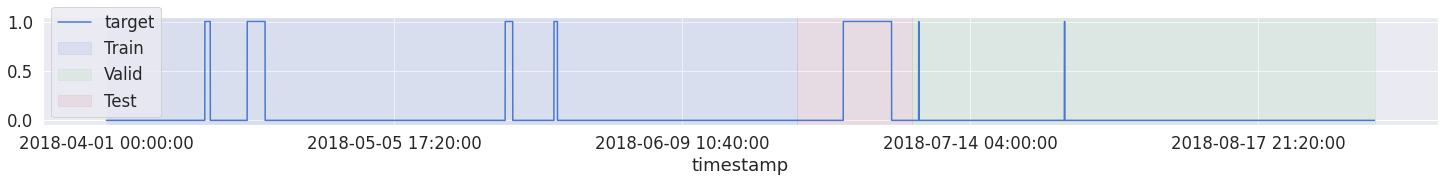

In [ ]:
fig, ax = plt.subplots(figsize=(25, 2))
data_shift.iloc[:, -1].plot(ax=ax)
ax.axvspan(0, 120000, alpha=0.1, color='b', label='Train')
ax.axvspan(140000, data_shift.shape[0], alpha=0.1, color='g', label='Valid')
ax.axvspan(120000, 140000, alpha=0.1, color='r', label='Test')
ax.legend()

In [ ]:
# reshape for input 
timesteps = 1
samples_train = int(np.floor(X_train.shape[0] / timesteps))
samples_valid = int(np.floor(X_valid.shape[0] / timesteps))
samples_test = int(np.floor(X_test.shape[0] / timesteps))

X_train = X_train.reshape((samples_train, timesteps, X_train.shape[1])) #samples, timesteps, sensors   
X_valid = X_valid.reshape((samples_valid, timesteps, X_valid.shape[1]))       
X_test = X_test.reshape((samples_test, timesteps, X_test.shape[1])) 

In [ ]:
def model_setup(in_shape): 
    inputs= tf.keras.Input(shape=(in_shape[1], in_shape[2]))
    x = LSTM(50, activation='relu', input_shape=(in_shape[1], in_shape[2]), return_sequences=True)(inputs)
    x = LSTM(50, activation='relu')(x)
    out = Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=out)
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam')
    
    print(model.summary())
    return model  

In [ ]:
inputshape_X = (X_train.shape)
model = model_setup(inputshape_X)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_valid, y_valid), shuffle=False)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 49)]           0         
                                                                 
 lstm (LSTM)                 (None, 1, 50)             20000     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 40,251
Trainable params: 40,251
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
3750/3750 [==============================] - 20s 5ms/step - loss: 0.1620 - val_loss: 0.0128
Epoch 2/100
3750/3750 [==============================] - 19s 5ms/step - loss: 0.

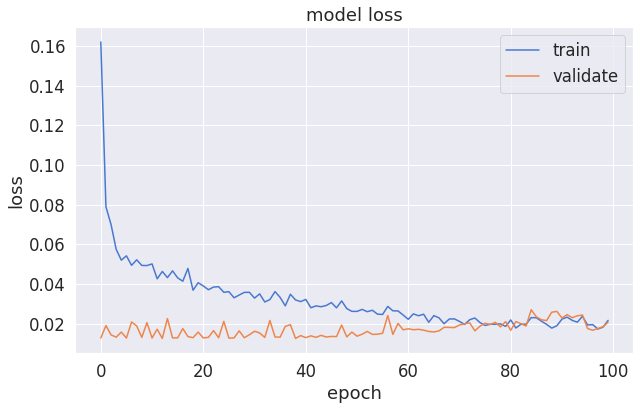

In [ ]:
# Loss history plot
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

In [ ]:
y_pred_train = model.predict(X_train).reshape((1, -1))[0]

3750/3750 [==============================] - 7s 2ms/step


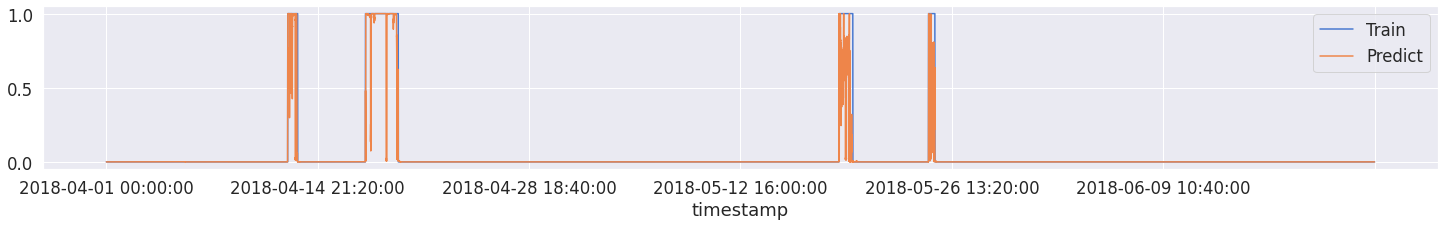

In [ ]:
ind = range(120000)

fig, ax = plt.subplots(figsize=(25, 3))
data.iloc[ind, -1].plot(ax=ax, label='Train')
ax.plot(data.iloc[ind, -1].index, y_pred_train, label='Predict')
ax.legend()

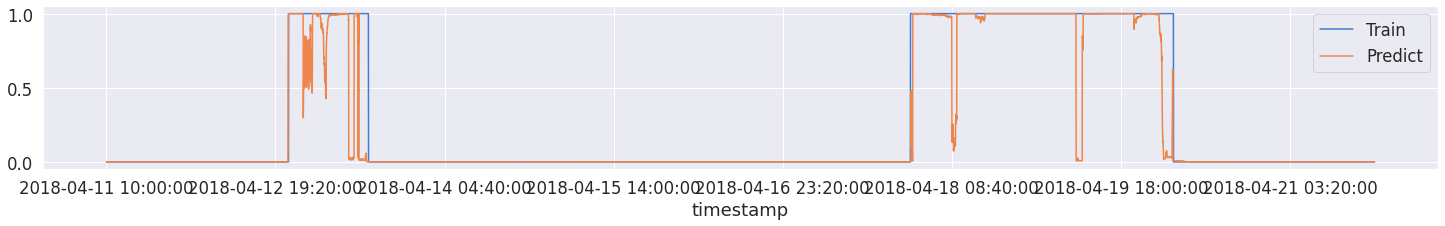

In [ ]:
ind = range(15000, 30000)

fig, ax = plt.subplots(figsize=(25, 3))
data.iloc[ind, -1].plot(ax=ax, label='Train')
ax.plot(data.iloc[ind, -1].index, y_pred_train[15000:30000], label='Predict')
ax.legend()

In [ ]:
y_pred_valid = model.predict(X_valid).reshape((1, -1))[0]

2509/2509 [==============================] - 5s 2ms/step


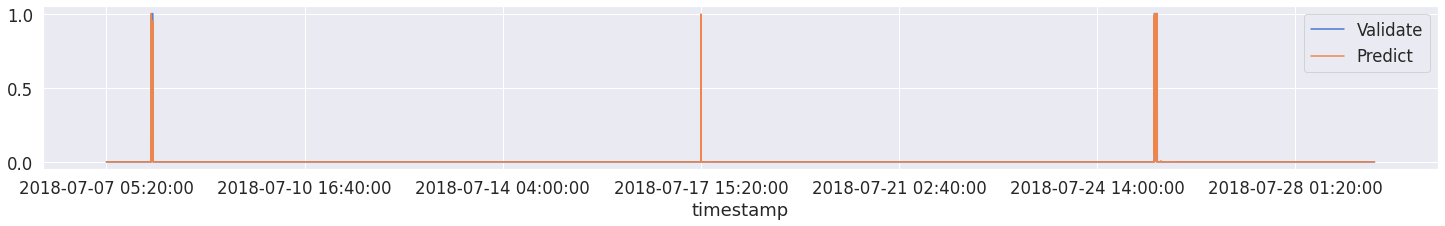

In [ ]:
ind = range(140000, 172000)

fig, ax = plt.subplots(figsize=(25, 3))
data.iloc[ind, -1].plot(ax=ax, label='Validate')
ax.plot(data.iloc[ind, -1].index, y_pred_valid[:32000], label='Predict')
ax.legend()

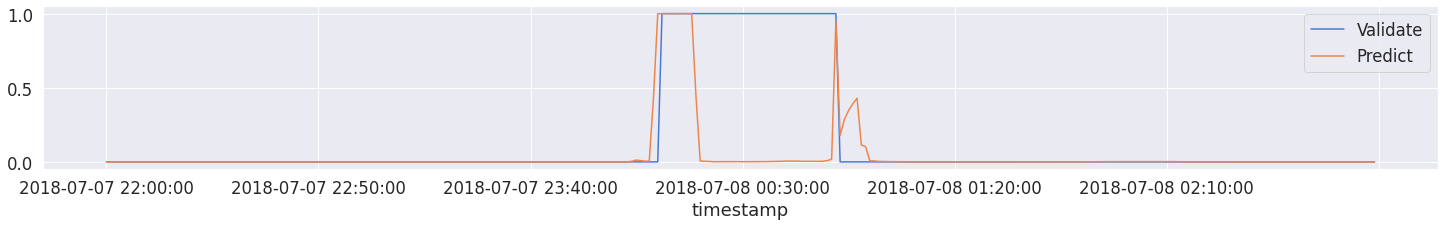

In [ ]:
ind = range(141000, 141300)

fig, ax = plt.subplots(figsize=(25, 3))
data.iloc[ind, -1].plot(ax=ax, label='Validate')
ax.plot(data.iloc[ind, -1].index, y_pred_valid[1000:1300], label='Predict')
ax.legend()

In [ ]:
y_pred_test = model.predict(X_test).reshape((1, -1))[0]

625/625 [==============================] - 1s 2ms/step


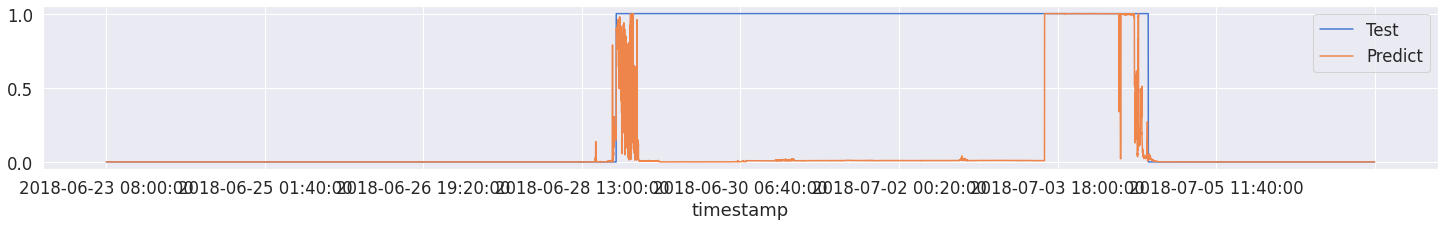

In [ ]:
ind = range(120000, 140000)

fig, ax = plt.subplots(figsize=(25, 3))
data.iloc[ind, -1].plot(ax=ax, label='Test')
ax.plot(data.iloc[ind, -1].index, y_pred_test, label='Predict')
ax.legend()

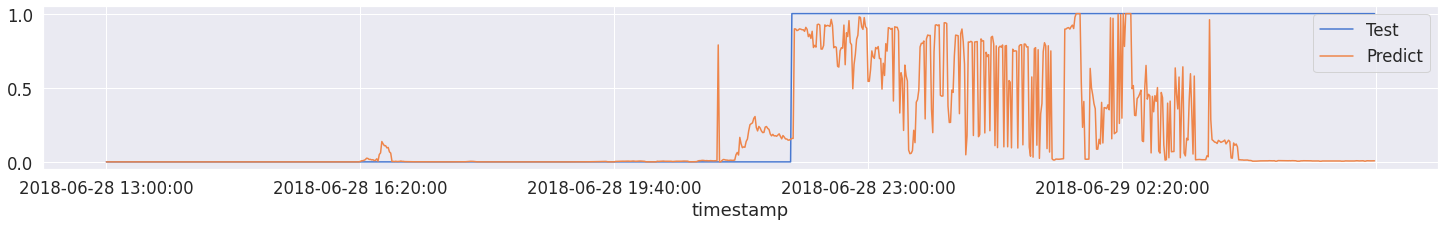

In [ ]:
ind1 = range(127500, 128500)
ind2 = range(7500, 8500)

fig, ax = plt.subplots(figsize=(25, 3))
data.iloc[ind1, -1].plot(ax=ax, label='Test')
ax.plot(data.iloc[ind1, -1].index, y_pred_test[ind2], label='Predict')
ax.legend()